In [56]:
import pathlib
from motion_imitation.envs import env_builder

root_dir = pathlib.Path('./').absolute().parent
data_dir = root_dir / 'motion_imitation' / 'data'
pace_motion_file = str(data_dir / 'motions' / 'dog_pace.txt')

def get_motion_data(motion_file_path = pace_motion_file):
    env = env_builder.build_imitation_env(motion_files=[motion_file_path],
                                        num_parallel_envs=1,
                                        mode='test',
                                        enable_randomizer=False,
                                        enable_rendering=False)


    motion_data = env.task.get_active_motion()
    return motion_data

motion_data = get_motion_data()

argv[0]=


/home/daniel/anaconda3/envs/motion_imitation/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [1]:
import pathlib
from motion_imitation.envs import env_builder



pybullet build time: Dec  1 2021 18:33:04
/home/daniel/.local/lib/python3.7/site-packages/motion_imitation-0.0.6-py3.7-linux-x86_64.egg/motion_imitation/robots/a1.py:104: RuntimeWarning: invalid value encountered in arccos
  (2 * l_low * l_up))
/home/daniel/anaconda3/envs/motion_imitation/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


argv[0]=


/home/daniel/anaconda3/envs/motion_imitation/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


39
(19,)
0.63346
0.01667


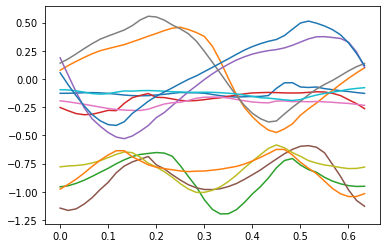

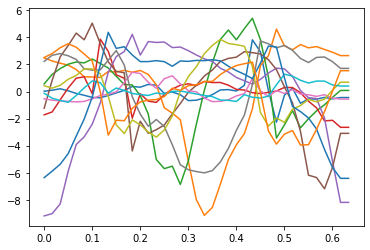

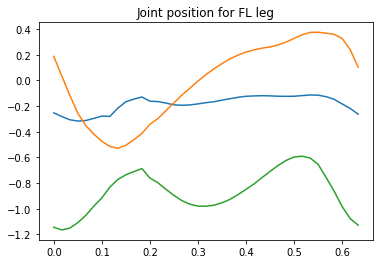

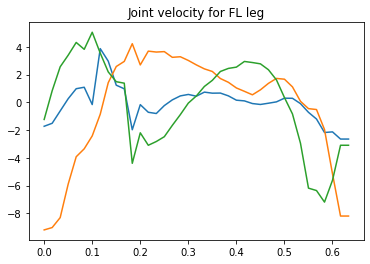

In [3]:
import numpy as np
import matplotlib.pyplot as plt 

motion_data = get_motion_data()
num_frames = motion_data.get_num_frames()
print(num_frames)
frame_dim = motion_data.get_frame(0).shape
print(frame_dim)
print(motion_data.get_duration())
frame_dur = motion_data.get_frame_duration()
print(frame_dur)

joint_positions = np.zeros((num_frames, 12))
joint_velocities = np.zeros((num_frames, 12))
for i in range(num_frames):
    frame = motion_data.get_frame(i)
    frame_vel = motion_data.get_frame_vel(i)
    joint_positions[i] = motion_data.get_frame_joints(frame)
    joint_velocities[i] = motion_data.get_frame_joints_vel(frame_vel)

plt.figure()
# Inspect the cyclicity of the pose
# plt.plot(np.arange(num_frames * 2), np.vstack([joint_positions, joint_positions]))
plt.plot(np.arange(num_frames) * frame_dur, joint_positions)
plt.figure() 
plt.plot(np.arange(num_frames) * frame_dur, joint_velocities)


plt.figure() 
plt.title("Joint position for FL leg")
plt.plot(np.arange(num_frames) * frame_dur, joint_positions[:,3:6])
plt.figure() 
plt.title("Joint velocity for FL leg")
plt.plot(np.arange(num_frames) * frame_dur, joint_velocities[:,3:6])

# Learn to represent a single gait trajectories

Using SIREN

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

In [49]:
class PoseFitting(Dataset):
    def __init__(self, motion_data):
        super().__init__()
        self.motion_data = motion_data
        num_frames = motion_data.get_num_frames()  
        frame_dur = motion_data.get_frame_duration()
        frame_dim = motion_data.get_frame_size()

        self.coords = np.zeros((num_frames, 1)).astype(np.float32)
        self.values = np.zeros((num_frames, frame_dim)).astype(np.float32)
        for i in range(num_frames):
            self.coords[i] = i * frame_dur
            self.values[i] = motion_data.get_frame(i)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.values

In [50]:
dataset = PoseFitting(motion_data)
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
pose_siren = Siren(in_features=1, out_features=19, hidden_features=64, 
                  hidden_layers=2, outermost_linear=True)
pose_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=1, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Linear(in_features=64, out_features=19, bias=True)
  )
)

In [51]:
total_steps = 1500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=pose_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = pose_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.262140
Step 10, Total loss 0.205201
Step 20, Total loss 0.169572
Step 30, Total loss 0.137443
Step 40, Total loss 0.109445
Step 50, Total loss 0.086537
Step 60, Total loss 0.068721
Step 70, Total loss 0.055115
Step 80, Total loss 0.044786
Step 90, Total loss 0.036880
Step 100, Total loss 0.030746
Step 110, Total loss 0.025891
Step 120, Total loss 0.021949
Step 130, Total loss 0.018657
Step 140, Total loss 0.015873
Step 150, Total loss 0.013547
Step 160, Total loss 0.011632
Step 170, Total loss 0.010050
Step 180, Total loss 0.008732
Step 190, Total loss 0.007649
Step 200, Total loss 0.006764
Step 210, Total loss 0.006043
Step 220, Total loss 0.005451
Step 230, Total loss 0.004962
Step 240, Total loss 0.004548
Step 250, Total loss 0.004189
Step 260, Total loss 0.003874
Step 270, Total loss 0.003592
Step 280, Total loss 0.003336
Step 290, Total loss 0.003097
Step 300, Total loss 0.002872
Step 310, Total loss 0.002655
Step 320, Total loss 0.002448
Step 330, Total loss 

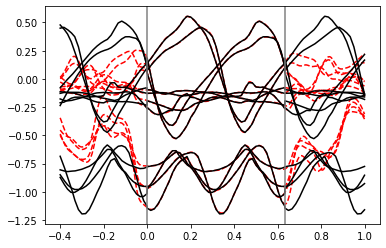

In [52]:
times = np.linspace(-0.4, 1.0, num=1400).astype(np.float32)
times = times.reshape(-1,1)
joint_positions = np.zeros((1400, 12))
device = torch.device('cuda:0')

with torch.no_grad():
    frame_pred, _ = pose_siren(torch.from_numpy(times).to(device))
    frame_pred = frame_pred.detach().cpu().numpy()
frame_true = np.zeros((1400, motion_data.get_frame_size()))
for i, t in enumerate(times):
    frame_true[i] = motion_data.calc_frame(t)

plt.plot(times, frame_pred[:, -12:], color = 'red', linestyle='--')
plt.plot(times, frame_true[:, -12:], color = 'black')
plt.axvline(x = 0, color = 'gray')
plt.axvline(x = motion_data.get_duration(), color = 'gray')


# Train SIREN to interpolate between gaits



In [114]:
motion_dir = data_dir / 'motions'
motion_files = { 
    'pace': motion_dir / 'dog_pace.txt',
    'trot': motion_dir / 'dog_trot.txt',
    'pace2': motion_dir / 'dog_pace.txt'
}

motion_datas = {
    name: get_motion_data(str(mf)) for name, mf in motion_files.items()
}


/home/daniel/anaconda3/envs/motion_imitation/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


argv[0]=
argv[0]=
argv[0]=


In [115]:
class PoseInterpolation(Dataset):
    def __init__(self, motion_data_dict, time_offset=1):
        super().__init__()
        self.motion_data_dict = motion_data_dict
        self.names = list(motion_data_dict.keys())
        self.coords = {}
        self.values = {}
        for name, motion_data in motion_data_dict.items():
            num_frames = motion_data.get_num_frames()  
            frame_dur = motion_data.get_frame_duration()
            frame_dim = motion_data.get_frame_size()

            self.coords[name] = np.zeros((num_frames, 1)).astype(np.float32)
            self.values[name] = np.zeros((num_frames, frame_dim)).astype(np.float32)
            for i in range(num_frames):
                self.coords[name][i] = i * frame_dur
                self.values[name][i] = motion_data.get_frame(i)
            
        # Add 1 second offset to each consecutive time
        for j, name in enumerate(self.names):
            self.coords[name] += j * time_offset

        self.coords = np.concatenate(list(self.coords.values()), axis=0)
        self.values = np.concatenate(list(self.values.values()), axis=0)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.values

In [116]:
dataset = PoseInterpolation(motion_datas)

In [117]:
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
pose_siren = Siren(in_features=1, out_features=19, hidden_features=64, 
                  hidden_layers=2, outermost_linear=True)
pose_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=1, out_features=64, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=64, out_features=64, bias=True)
    )
    (3): Linear(in_features=64, out_features=19, bias=True)
  )
)

In [118]:
total_steps = 1500 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-4, params=pose_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = pose_siren(model_input)    
    loss = ((model_output - ground_truth)**2).mean()
    
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))

    optim.zero_grad()
    loss.backward()
    optim.step()

Step 0, Total loss 0.231558
Step 10, Total loss 0.183076
Step 20, Total loss 0.150230
Step 30, Total loss 0.119906
Step 40, Total loss 0.094584
Step 50, Total loss 0.074942
Step 60, Total loss 0.060427
Step 70, Total loss 0.049751
Step 80, Total loss 0.041811
Step 90, Total loss 0.035753
Step 100, Total loss 0.030961
Step 110, Total loss 0.027046
Step 120, Total loss 0.023736
Step 130, Total loss 0.020928
Step 140, Total loss 0.018556
Step 150, Total loss 0.016522
Step 160, Total loss 0.014767
Step 170, Total loss 0.013249
Step 180, Total loss 0.011942
Step 190, Total loss 0.010820
Step 200, Total loss 0.009855
Step 210, Total loss 0.009014
Step 220, Total loss 0.008273
Step 230, Total loss 0.007611
Step 240, Total loss 0.007014
Step 250, Total loss 0.006473
Step 260, Total loss 0.005983
Step 270, Total loss 0.005534
Step 280, Total loss 0.005123
Step 290, Total loss 0.004745
Step 300, Total loss 0.004399
Step 310, Total loss 0.004085
Step 320, Total loss 0.003800
Step 330, Total loss 

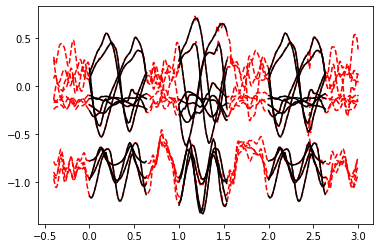

In [121]:
times = np.linspace(-0.4, 3.0, num=3400).astype(np.float32)
times = times.reshape(-1,1)
joint_positions = np.zeros((3400, 12))
device = torch.device('cuda:0')

with torch.no_grad():
    frame_pred, _ = pose_siren(torch.from_numpy(times).to(device))
    frame_pred = frame_pred.detach().cpu().numpy()
    
frame_true = np.zeros((3400, motion_data.get_frame_size()))
for i, t in enumerate(times):
    if t > 0 and t < motion_datas['pace'].get_duration():
        frame_true[i] = motion_datas['pace'].calc_frame(t)
    elif t > 1 and t < 1 + motion_datas['trot'].get_duration():
        frame_true[i] = motion_datas['trot'].calc_frame(t-1)
    elif t > 2 and t < 2 + motion_datas['pace'].get_duration():
        frame_true[i] = motion_datas['pace'].calc_frame(t-2)
    else:
        frame_true[i] = np.nan

plt.plot(times, frame_pred[:, -12:], color = 'red', linestyle='--')
plt.plot(times, frame_true[:, -12:], color = 'black')


In [ ]:
frames = 

# Save predicted pose transition to motion file
motion_json = {
    "LoopMode": "Wrap",
    "FrameDuration": 0.01667,
    "EnableCycleOffsetPosition": True,
    "EnableCycleOffsetRotation": False,

    "Frames": 
}

# Learn to represent multiple gait trajectories

Using modulated SIREN

In [59]:
motion_dir = data_dir / 'motions'
motion_files = { 
    'pace': motion_dir / 'dog_pace.txt',
    'trot': motion_dir / 'dog_trot.txt'
}

motion_datas = {
    name: get_motion_data(str(mf)) for name, mf in motion_files.items()
}


argv[0]=
argv[0]=


In [61]:
class PoseFitting(Dataset):
    def __init__(self, motion_data_dict):
        super().__init__()
        self.motion_data_dict = motion_data_dict
        self.names = motion_data_dict.keys()
        self.coords = {}
        self.values = {}
        for name, motion_data in motion_data_dict.items():
            num_frames = motion_data.get_num_frames()  
            frame_dur = motion_data.get_frame_duration()
            frame_dim = motion_data.get_frame_size()

            self.coords[name] = np.zeros((num_frames, 1)).astype(np.float32)
            self.values[name] = np.zeros((num_frames, frame_dim)).astype(np.float32)
            for i in range(num_frames):
                self.coords[name][i] = i * frame_dur
                self.values[name][i] = motion_data.get_frame(i)

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[i]    
        return self.coords[name], self.values[name]

In [70]:
import torch
from gon_pytorch import IdentityPositionalEncoding, ImplicitDecoder, GON, SirenBlockFactory

pos_encoder = IdentityPositionalEncoding(in_dim=1)
decoder = ImplicitDecoder(
    latent_dim=8,
    out_dim=19,
    hidden_dim=32,
    num_layers=2,
    block_factory=SirenBlockFactory(),
    pos_encoder=pos_encoder
)
gon = GON(decoder).cuda()

In [71]:
total_steps = 3000 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 10

optim = torch.optim.Adam(lr=1e-3, params=gon.parameters())

for model_input, ground_truth in iter(dataloader):

    model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
    for step in range(total_steps):
        
        latents, inner_loss = gon.infer_latents(model_input, ground_truth)
        model_output = gon(model_input, latents)
        loss = ((model_output - ground_truth)**2).mean()
        
        if not step % steps_til_summary:
            print("Step %d, Total loss %0.6f" % (step, loss))
    
        optim.zero_grad()
        loss.backward()
        optim.step()

Step 0, Total loss 0.544268
Step 10, Total loss 0.473396
Step 20, Total loss 0.405412
Step 30, Total loss 0.344724
Step 40, Total loss 0.301784
Step 50, Total loss 0.270699
Step 60, Total loss 0.249387
Step 70, Total loss 0.234681
Step 80, Total loss 0.224316
Step 90, Total loss 0.216743
Step 100, Total loss 0.211036
Step 110, Total loss 0.206599
Step 120, Total loss 0.203059
Step 130, Total loss 0.200175
Step 140, Total loss 0.197784
Step 150, Total loss 0.195771
Step 160, Total loss 0.194055
Step 170, Total loss 0.192575
Step 180, Total loss 0.191288
Step 190, Total loss 0.190162
Step 200, Total loss 0.189167
Step 210, Total loss 0.188282
Step 220, Total loss 0.187492
Step 230, Total loss 0.186782
Step 240, Total loss 0.186142
Step 250, Total loss 0.185561
Step 260, Total loss 0.185033
Step 270, Total loss 0.184550
Step 280, Total loss 0.184108
Step 290, Total loss 0.183703
Step 300, Total loss 0.183328
Step 310, Total loss 0.182983
Step 320, Total loss 0.182663
Step 330, Total loss 

In [ ]:
times = np.linspace(-0.4, 1.0, num=1400).astype(np.float32)
times = times.reshape(-1,1)
joint_positions = np.zeros((1400, 12))
device = torch.device('cuda:0')

with torch.no_grad():
    frame_pred, _ = pose_siren(torch.from_numpy(times).to(device))
    frame_pred = frame_pred.detach().cpu().numpy()
frame_true = np.zeros((1400, motion_data.get_frame_size()))
for i, t in enumerate(times):
    frame_true[i] = motion_data.calc_frame(t)

plt.plot(times, frame_pred[:, -12:], color = 'red', linestyle='--')
plt.plot(times, frame_true[:, -12:], color = 'black')
plt.axvline(x = 0, color = 'gray')
plt.axvline(x = motion_data.get_duration(), color = 'gray')
